# Example 6

In this example, we evolve a list of  binary systems (in the file [listBin.dat](listBin.dat)) to analyse the merging binary neutron star systems (BNSs)

    - We show how to merge the output file with the evolved file to get the initial properties of the binar.
    - We show how to filter the systems that produce BNSs, the one ending with a stellar merger and the one that have been broken after a SN kick. 
    - We show how to read information from the logfile and merge them with the output file
    - We show how to produce a plot showing the number of CE undergo by the BNSs
    - We show how to focus on a single system, retrieve its initial condition, re-run a simulation with the same random seed. 
    - Finally, we show how to estiamte the delay time for the BNS merger

- To compile SEVN use the [compile.sh](compile.sh) script
- The run  use [run_onlyend.sh](run_onlyend.sh), DTOUT set to end
- To run the single system (in [IC_special.dat](IC_special.dat)) use: [run_special.sh](run_special.sh), DTOUT is set to all and RSEED is set to true (the random seed is included in the input file)

Remember to set the proper SEVN path in the compile and run scripts

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
df=pd.read_csv("sevn_output/output_0.csv")

#First take only the systems at the end 
dff=df[df.BWorldtime>0]
#Now alternative version to link to the initial coniditions using not the evolved but the initial values
dfini=df[df.BWorldtime==0]
#Merge
dff=dff.merge(dfini, on=["ID","name"], suffixes=("","_ini"),how="inner")

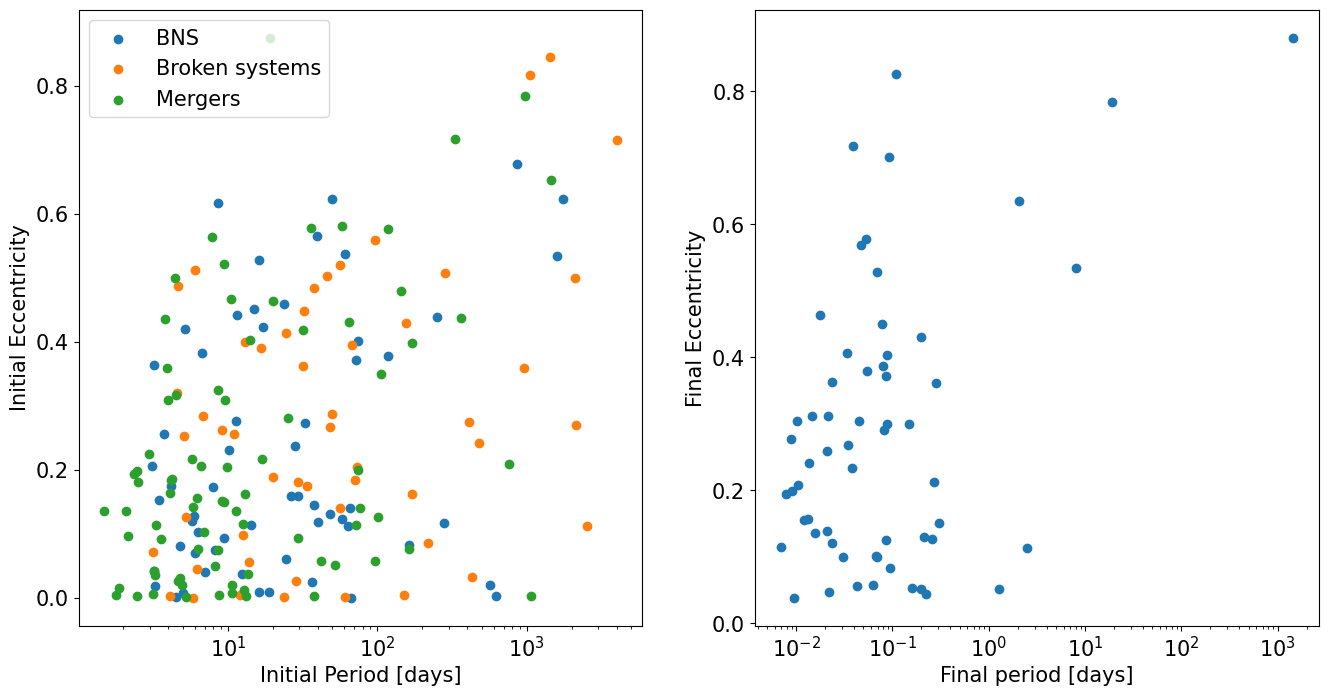

In [9]:
#Plot the initial and final properties of the systems 
fig,axl=plt.subplots(1,2,figsize=(16,8))

#Separate BNS and broken systems 
#Broken systems have nan in the BInary properties
idxbns=(dff.Period>0) & ( (dff.RemnantType_0==4) | (dff.RemnantType_0==5) )  & ( (dff.RemnantType_1==4) | (dff.RemnantType_1==5) ) 
dffbns=dff[idxbns]
idxbroken = dff.Period.isnull() & (dff.Mass_0>0) & (dff.Mass_1>0)
idxmerger= dff.Mass_0.isnull() | dff.Mass_1.isnull()

plt.sca(axl[0])
plt.scatter(365.24*dffbns.Period_ini,dffbns.Eccentricity_ini,label="BNS") 
plt.scatter(365.24*dff.Period_ini[idxbroken],dff.Eccentricity_ini[idxbroken],label="Broken systems") 
plt.scatter(365.24*dff.Period_ini[idxmerger],dff.Eccentricity_ini[idxmerger],label="Mergers") 
plt.legend(fontsize=15)
plt.xscale("log")
plt.xlabel("Initial Period [days]",fontsize=15)
plt.ylabel("Initial Eccentricity",fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 

plt.sca(axl[1])
plt.scatter(365.24*dffbns.Period,dffbns.Eccentricity) 
plt.xscale("log")
plt.xlabel("Final period [days]",fontsize=15)
plt.ylabel("Final Eccentricity",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [10]:
#Now let's check how many CEs we need to produce a  BNS
#The information about the CE are in the  logfile 
#Let's define a funciton to read the CE in the logfile
import re 

def read_CElog(logfile):
    """
    Get the CE entries in the SEVN logfile
    :@param logfile complete path the logfile
    :@return a pandas Dataframe with the following columns
        - name: SEVN unique name of the bianry
        - ID: SEVN unique ID of the binary
        - time: time at which the CE is triggered [Myr]
        - id0: id of the Star in the binary that is considered the primary in the CE (usually the more evolved one)
        - m0: mass of the primary at the onset of the CE [Msun]
        - mhe0: helium core mass of the primary at the onset of the CE [Msun]
        - mco0: carbon-oxygen core mass of the primary at the onset of the CE [Msun]
        - phase0: SEVN phase of the primary at the onset of the CE
        - remnant0: Remnant type of the primary at the onset of the CE
        - id1: id of the Star in the binary that is considered the secondary in the CE (usually the less evolved one)
        - m1: mass of the secondary at the onset of the CE [Msun]
        - mhe1: helium core mass of the secondary at the onset of the CE [Msun]
        - mco1: carbon-oxygen core mass of the secondary at the onset of the CE [Msun]
        - phase1: SEVN phase of the secondary at the onset of the CE
        - remnant1: Remnant type of the secondary at the onset of the CE
        - a: semi-major axis at the onset of the CE [Rsun]
        - e: eccentricity at the onset of the CE
        - coalesce: CE ejection flag, 0 means that the CE was succesfully ejectes, 1 indicates a failed CE ending with a coalescence 
    """
    
    mnum="[[+|-]?[0-9]+\.?[0-9]*e?[+|-]?[0-9]*|(?i)nan]" #Match any number and nan
    mID="[0-9]+" #match IDS
    mname="(?:[0-9|A-Za-z]*\_)?[0-9]*" #match SEVN names 
    mtype="[+|-]?\d+" #Match stellar phase/types
    
    stardata=f"({mtype}):({mnum}):({mnum}):({mnum}):({mtype}):({mtype})"
    matchexpre=f"B;({mname});({mID});CE;({mnum});{stardata}:{stardata}:({mnum}):({mnum}):({mtype})"
    
    with  open(logfile,"r") as fo:
        fr=fo.read()
        ca=re.findall(matchexpre,fr)
    
    ca=np.array(ca)
    dfa={"name":np.array(ca[:,0], dtype=int),
        "ID":np.array(ca[:,1], dtype=int)}
    
    caf=np.array(ca[:,2:], dtype=np.float64)
    
    name_list=("time","id0","m0","mhe0","mco0","phase0","remnant0","id1","m1","mhe1","mco1","phase1","remnant1",
              "a","e","coalesce")
    
    for j,name in enumerate(name_list):
        dfa[name]=caf[:,j]
    
    return pd.DataFrame.from_dict(dfa)



In [11]:
#Load CE info
logCE=read_CElog("sevn_output/logfile_0.dat")
display(logCE)

#Now count the nunbe of CE occurences for each binary
logCE.groupby(["name"]).size().reset_index()

/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000gn/T/ipykernel_66387/2527966062.py:41: FutureWarning: Possible nested set at position 45
  ca=re.findall(matchexpre,fr)
/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000gn/T/ipykernel_66387/2527966062.py:41: DeprecationWarning: Flags not at the start of the expression 'B;((?:[0-9|A-Za-z]*\\' (truncated) but at position 81
  ca=re.findall(matchexpre,fr)
/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000gn/T/ipykernel_66387/2527966062.py:41: FutureWarning: Possible nested set at position 105
  ca=re.findall(matchexpre,fr)
/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000gn/T/ipykernel_66387/2527966062.py:41: DeprecationWarning: Flags not at the start of the expression 'B;((?:[0-9|A-Za-z]*\\' (truncated) but at position 141
  ca=re.findall(matchexpre,fr)
/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000gn/T/ipykernel_66387/2527966062.py:41: FutureWarning: Possible nested set at position 153
  ca=re.findall(matchexpre,fr)
/var/folders/cs/crwwm3z903z8pfv63c5k3f1h0000g

name   ID      time  id0      m0   mhe0   mco0  phase0  \
0    958520230611592    1  22.31882  1.0  13.240  3.338  0.000     4.0   
1    958520230611592    1  23.77742  1.0   3.278  3.278  1.633     6.0   
2    985909462849940    3  18.87043  1.0  14.830  3.956  0.000     4.0   
3    941288691142729    5  18.94358  1.0  14.530  3.970  0.000     4.0   
4    589758776337728    6  14.24662  0.0  13.000  3.255  0.000     3.0   
..               ...  ...       ...  ...     ...    ...    ...     ...   
269  457034930264292  196  20.64136  1.0  11.250  3.644  0.000     3.0   
270  457034930264292  196  21.98113  1.0   3.439  3.439  1.736     6.0   
271  853138417033517  198  18.10753  1.0  15.110  5.396  3.237     6.0   
272  853138417033517  198  18.11305  1.0   5.394  5.394  3.245     6.0   
273  899118925047897  199  11.20963  0.0  14.930  4.466  0.000     3.0   

     remnant0  id1      m1   mhe1  mco1  phase1  remnant1           a  \
0         0.0  0.0   1.193  0.000   0.0     7.0       5.0   79.806420   
1         0.0  0.0   1.195  0.000   0.0     7.0       5.0    1.576651   
2         0.0  0.0   2.789  2.789   0.0     4.0       0.0   50.502450   
3         0.0  0.0   1.193  0.000   0.0     7.0       5.0   26.465110   
4         0.0  1.0  12.190  0.000   0.0     1.0       0.0  168.436700   
..        ...  ...     ...    ...   ...     ...       ...         ...   
269       0.0  0.0   1.193  0.000   0.0     7.0       5.0    1.355055   
270       0.0  0.0   1.200  0.000   0.0     7.0       5.0    1.422186   
271       0.0  0.0   1.380  0.000   0.0     7.0       5.0  862.331400   
272       0.0  0.0   1.380  0.000   0.0     7.0       5.0    1.287054   
273       0.0  1.0  13.970  0.000   0.0     1.0       0.0  142.597000   

              e  coalesce  
0      1.429461       0.0  
1      0.177801       0.0  
2      1.255605       1.0  
3      0.959627       0.0  
4     84.945070       0.0  
..          ...       ...  
269    1.292777       0.0  
270    0.159240       1.0  
271    1.259646       0.0  
272    0.163188       1.0  
273  105.655600       0.0  

[274 rows x 18 columns]

name  0
0    110128571876882  1
1    125366727362793  1
2    131223410392209  2
3    134080567686993  2
4    137520356777517  1
..               ... ..
151  974091344790745  2
152  985909462849940  1
153  986093996095496  1
154  988777702706202  1
155  995401329805442  1

[156 rows x 2 columns]

In [12]:
#Now count the nunbe of CE occurences for each binary
counts=logCE.groupby(["name"]).size()
display(counts)
#Put it in a proper dataframe
countCE=pd.DataFrame({'nCE' : counts}).reset_index()
display(countCE)

name
110128571876882    1
125366727362793    1
131223410392209    2
134080567686993    2
137520356777517    1
                  ..
974091344790745    2
985909462849940    1
986093996095496    1
988777702706202    1
995401329805442    1
Length: 156, dtype: int64

name  nCE
0    110128571876882    1
1    125366727362793    1
2    131223410392209    2
3    134080567686993    2
4    137520356777517    1
..               ...  ...
151  974091344790745    2
152  985909462849940    1
153  986093996095496    1
154  988777702706202    1
155  995401329805442    1

[156 rows x 2 columns]

In [13]:
#Xmatch
#NOTICE, we use left because not all the systems undergo a CE, we do not want to remove them but rather put 0 in the nCE column
dffCE=dffbns.merge(countCE, on=["name"], how="left")
#Trasform nan to 0 in the nCE column
dffCE['nCE'] = dffCE['nCE'].fillna(0)
display(dffCE)

ID             name    Mass_0  MHE_0  MCO_0  Radius_0  Luminosity_0  \
0     1  958520230611592  1.195295    0.0    0.0  0.000016      0.001957   
1    14  769694571792916  1.264707    0.0    0.0  0.000016      0.004816   
2    18  263829564731449  1.195027    0.0    0.0  0.000016      0.001298   
3    20  509890278904522  1.193299    0.0    0.0  0.000016      0.142402   
4    24  750838268192143  1.197188    0.0    0.0  0.000016      0.004525   
5    25  351607855351817  1.197104    0.0    0.0  0.000016      0.001536   
6    26  702546254111536  1.311716    0.0    0.0  0.000016      0.117664   
7    29  389594616601820  1.194956    0.0    0.0  0.000016      0.024300   
8    34  366384771281248  1.195373    0.0    0.0  0.000016      0.000421   
9    46  919806886913497  1.196738    0.0    0.0  0.000016      0.010361   
10   51  420399985106015  1.283620    0.0    0.0  0.000016      2.362223   
11   59  956062249732188  1.194622    0.0    0.0  0.000016      0.000483   
12   67  488567154072224  1.195345    0.0    0.0  0.000016      0.035451   
13   70  318683100580945  1.193514    0.0    0.0  0.000016      2.250341   
14   71  365474005978816  1.194671    0.0    0.0  0.000016      0.097529   
15   72  864534664449687  1.194298    0.0    0.0  0.000016      0.027502   
16   75  303393081140850  1.193301    0.0    0.0  0.000016      0.002753   
17   77  297555064414792  1.193223    0.0    0.0  0.000016      2.249976   
18   78  496718267679996  1.309191    0.0    0.0  0.000016      0.000521   
19   79  320450484806455  1.194333    0.0    0.0  0.000016      0.090545   
20   80  559402760230564  1.193357    0.0    0.0  0.000016      0.006147   
21   82  518607800510858  1.307597    0.0    0.0  0.000016      0.041421   
22   85  877050253033924  1.510376    0.0    0.0  0.000016      0.000392   
23   87  958772111586256  1.193378    0.0    0.0  0.000016      0.000243   
24   90  516426257406713  1.194056    0.0    0.0  0.000016      0.087048   
25   92  620381588750329  1.195921    0.0    0.0  0.000016      0.058275   
26   94  974091344790745  1.193352    0.0    0.0  0.000016      0.000157   
27   96  409493733167887  1.564137    0.0    0.0  0.000016      0.000486   
28  101  357119883793104  1.193482    0.0    0.0  0.000016      0.112516   
29  102  235095212546073  1.195943    0.0    0.0  0.000016      0.013997   
30  105  243306621053233  1.193309    0.0    0.0  0.000016      0.007468   
31  107  741413841683962  1.193285    0.0    0.0  0.000016      0.000668   
32  108  277110314831300  1.264548    0.0    0.0  0.000016      0.001224   
33  109  462031507405198  1.196796    0.0    0.0  0.000016      0.002549   
34  111  747597165711419  1.195061    0.0    0.0  0.000016      0.001788   
35  114  606376524703744  1.267877    0.0    0.0  0.000016      0.003401   
36  115  903332383586022  1.194643    0.0    0.0  0.000016      0.008739   
37  118  504185940610512  1.194239    0.0    0.0  0.000016      0.003041   
38  122  903137349581208  1.199478    0.0    0.0  0.000016      0.002717   
39  124  843117093595309  1.193245    0.0    0.0  0.000016      0.037761   
40  128  173834624951899  1.193670    0.0    0.0  0.000016      0.000497   
41  134  424800676439245  1.196184    0.0    0.0  0.000016      0.022742   
42  138  832799180749456  1.195576    0.0    0.0  0.000016      0.002579   
43  143  212278172625276  1.308796    0.0    0.0  0.000016      0.002573   
44  144  751796750868863  1.195359    0.0    0.0  0.000016      0.029230   
45  147  599227272537541  1.194897    0.0    0.0  0.000016      0.001533   
46  148  823911559496916  1.195682    0.0    0.0  0.000016      0.001351   
47  149  134080567686993  1.194282    0.0    0.0  0.000016      0.001896   
48  151  803584818322604  1.195401    0.0    0.0  0.000016      0.120193   
49  152  145927463203134  1.274298    0.0    0.0  0.000016      0.002035   
50  153  421284226187570  1.534508    0.0    0.0  0.000016      0.112884   
51  154  550169569082278  1.193578    0.0    0.0  0.0

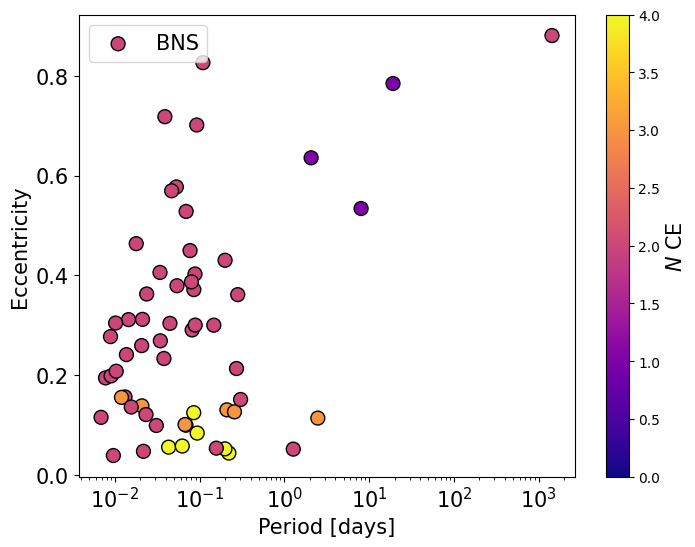

In [33]:
#Finally plot!

fig=plt.figure(figsize=(8,6))

#Separate BNS and broken systems 
#Broken systems have nan in the BInary properties

plt.scatter(365.24*dffCE.Period,dffCE.Eccentricity,c=dffCE.nCE,label="BNS",cmap="plasma",
           vmin=0,vmax=4,s=100,ec="k") 
cbar = plt.colorbar()
cbar.set_label('$N$ CE',fontsize=15)
plt.legend(fontsize=15)
plt.xscale("log")
plt.xlabel("Period [days]",fontsize=15)
plt.ylabel("Eccentricity",fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 

plt.show()

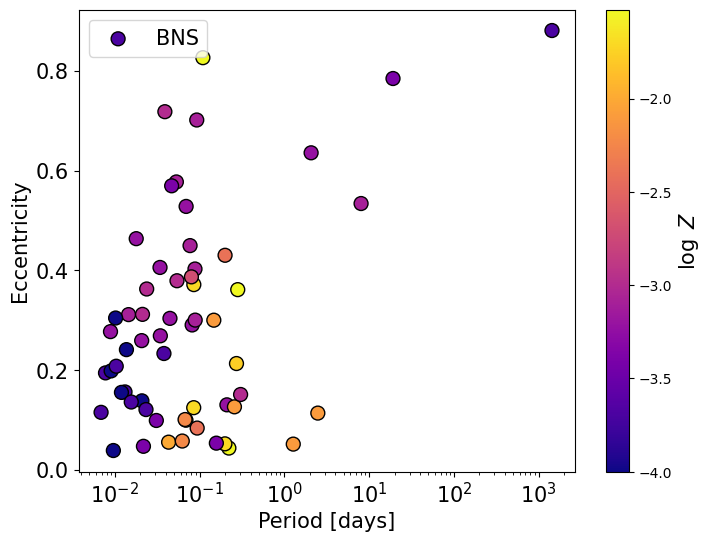

In [34]:
#Metallicity?

fig=plt.figure(figsize=(8,6))

#Separate BNS and broken systems 
#Broken systems have nan in the BInary properties

plt.scatter(365.24*dffCE.Period,dffCE.Eccentricity,c=np.log10(dffCE.Zmet_0),label="BNS",cmap="plasma",s=100,ec="k") 
cbar=plt.colorbar()
cbar.set_label('$\log \ Z$',fontsize=15)
plt.legend(fontsize=15)
plt.legend(fontsize=15)
plt.xscale("log")
plt.xlabel("Period [days]",fontsize=15)
plt.ylabel("Eccentricity",fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 

plt.show()

In [16]:
#Let's give a look to the systems with 4 CE episodes
df4=dffCE[dffCE.nCE==4]
display(df4)
#Their are 8 let's take the first one name and get the IC from the evolved file
name=df4["name"].iloc[0]
#load the evolved file 
dfev=pd.read_csv("sevn_output/evolved_0.dat",sep="\s+")
#Just get the info of the  system
dfev=dfev[dfev.name==name]
#Just create a new IC file including also the seed, 
##Drop the columns not needed for the IC: name, ID
dfev=dfev.drop(columns=["#ID","name"])
print(dfev)
#save if
dfev.to_csv("IC_special.dat",sep=" ",index=False,header=False)

#Now just run again the simulation printing all the steps

ID             name    Mass_0  MHE_0  MCO_0  Radius_0  Luminosity_0  \
12   67  488567154072224  1.195345    0.0    0.0  0.000016      0.035451   
14   71  365474005978816  1.194671    0.0    0.0  0.000016      0.097529   
15   72  864534664449687  1.194298    0.0    0.0  0.000016      0.027502   
19   79  320450484806455  1.194333    0.0    0.0  0.000016      0.090545   
24   90  516426257406713  1.194056    0.0    0.0  0.000016      0.087048   
29  102  235095212546073  1.195943    0.0    0.0  0.000016      0.013997   
36  115  903332383586022  1.194643    0.0    0.0  0.000016      0.008739   

    Temperature_0  Phase_0  RemnantType_0  ...  Phase_1_ini  \
12       629868.0        7              5  ...            1   
14       811193.2        7              5  ...            1   
15       591128.8        7              5  ...            1   
19       796263.9        7              5  ...            1   
24       788461.5        7              5  ...            1   
29       499288.2        7              5  ...            1   
36       443817.0        7              5  ...            1   

    RemnantType_1_ini  Zmet_1_ini  BWorldtime_ini  Semimajor_ini  \
12                  0       0.010             0.0          110.0   
14                  0       0.014             0.0          104.0   
15                  0       0.030             0.0         1140.0   
19                  0       0.006             0.0          135.0   
24                  0       0.004             0.0          161.0   
29                  0       0.020             0.0           88.0   
36                  0       0.020             0.0          863.0   

    Eccentricity_ini  BEvent_ini  Period_ini    GWtime_ini  nCE  
12            0.1590          -1    0.072869  5.003055e+06    4  
14            0.0606          -1    0.066666  4.204836e+06    4  
15            0.6770          -1    2.359760  6.149300e+09    4  
19            0.0247          -1    0.099968  1.311564e+07    4  
24            0.1310          -1    0.131554  2.657384e+07    4  
29            0.0084          -1    0.051281  2.036320e+06    4  
36            0.0196          -1    1.562819  1.796906e+10    4  

[7 rows x 51 columns]

    Mass_0   Z_0  spin_0   SN_0 Tstart_0  Mass_1   Z_1  spin_1   SN_1  \
67  12.821  0.01     0.0  rapid     zams  12.392  0.01     0.0  rapid   

   Tstart_1      a      e Tend Dtout             Seed  
67     zams  110.0  0.159  end   end  535487383643839  


ID             name     Mass_0  MHE_0  MCO_0  Radius_0  Luminosity_0  \
0     0  488567154072224  12.820250    0.0    0.0  4.090912  12481.800000   
1     0  488567154072224  12.817750    0.0    0.0  4.323585  13264.170000   
2     0  488567154072224  12.815430    0.0    0.0  4.551608  14034.970000   
3     0  488567154072224  12.812590    0.0    0.0  4.794568  14980.430000   
4     0  488567154072224  12.809630    0.0    0.0  5.054486  16028.560000   
..   ..              ...        ...    ...    ...       ...           ...   
392   0  488567154072224   1.195327    0.0    0.0  0.000016      0.037391   
393   0  488567154072224   1.195345    0.0    0.0  0.000016      0.037302   
394   0  488567154072224   1.195345    0.0    0.0  0.000016      0.037302   
395   0  488567154072224   1.195345    0.0    0.0  0.000016      0.037302   
396   0  488567154072224   1.195345    0.0    0.0  0.000016      0.035451   

     Temperature_0  Phase_0  PhaseBSE_0  ...  Phase_1  PhaseBSE_1  \
0         30163.78        1         1.0  ...        1         1.0   
1         29790.28        1         1.0  ...        1         1.0   
2         29447.41        1         1.0  ...        1         1.0   
3         29163.05        1         1.0  ...        1         1.0   
4         28887.62        1         1.0  ...        1         1.0   
..             ...      ...         ...  ...      ...         ...   
392      638310.20        7        13.0  ...        6         8.0   
393      637930.60        7        13.0  ...        6         8.0   
394      637932.20        7        13.0  ...        6        12.0   
395      637932.20        7        13.0  ...        6        12.0   
396      629868.00        7        13.0  ...        7        13.0   

     RemnantType_1  Zmet_1  BWorldtime   Semimajor  Eccentricity  BEvent  \
0                0    0.01    0.000000  110.000000      0.159000      -1   
1                0    0.01    1.470959  110.018700      0.158999      -1   
2                0    0.01    2.837647  110.036000      0.158999      -1   
3                0    0.01    4.201682  110.056100      0.158998      -1   
4                0    0.01    5.547575  110.076800      0.158997      -1   
..             ...     ...         ...         ...           ...     ...   
392              0    0.01   17.303630    4.514350      0.021836      -1   
393              0    0.01   17.304560    4.514805      0.021823      -1   
394              0    0.01   17.304560    0.661397      0.000000      11   
395              0    0.01   17.304560    0.661397      0.000000      -1   
396              4    0.01   17.324580    0.700239      0.055566       0   

       Period        GWtime  
0    0.072869  5.003055e+06  
1    0.072894  5.009131e+06  
2    0.072917  5.014765e+06  
3    0.072944  5.021348e+06  
4    0.072972  5.028153e+06  
..        ...           ...  
392  0.001548  5.063892e+03  
393  0.001549  5.068293e+03  
394  0.000106  6.609548e+00  
395  0.000106  6.609548e+00  
396  0.000118  9.444785e+00  

[397 rows x 28 columns]

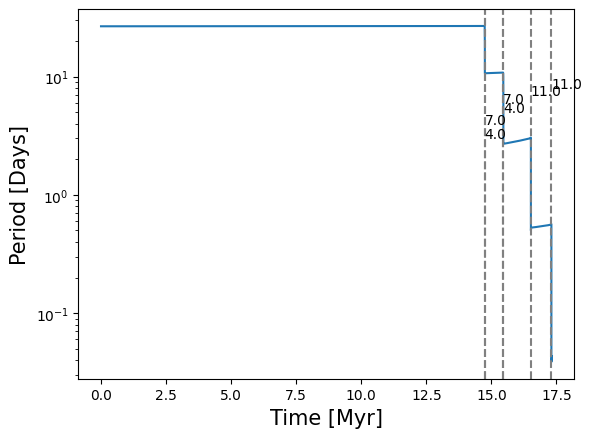

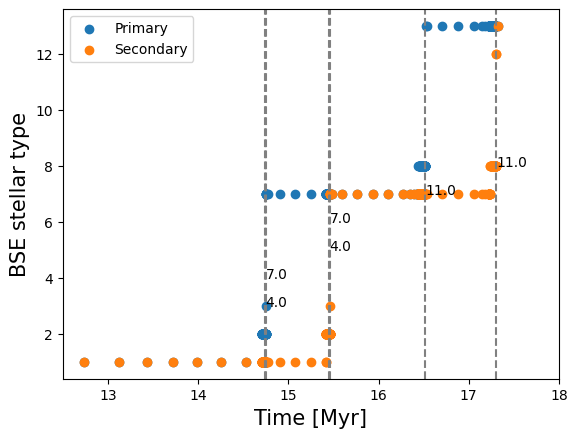

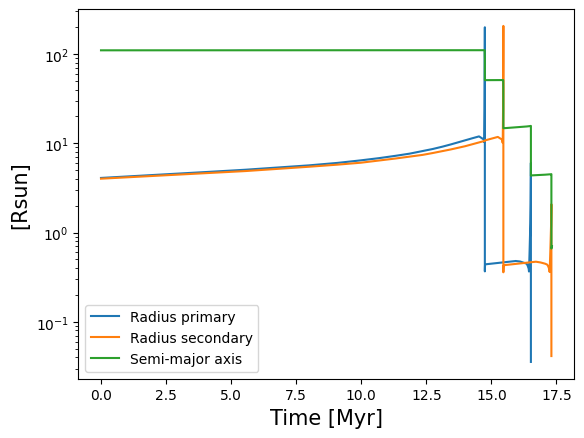

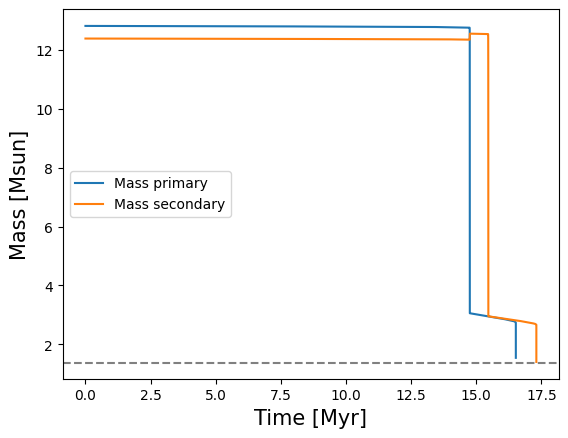

In [17]:
#Read the output
dfn=pd.read_csv("sevn_output_special/output_0.csv")
#Check the name is the same! (same random seed)
display(dfn)

plt.plot(dfn.BWorldtime, 365.24*dfn.Period)
i=0
for t,ev in dfn[dfn.BEvent>3][["BWorldtime","BEvent"]].values:
    
    plt.axvline(t,c="gray",ls="dashed")
    plt.text(t,3+i,ev)
    i+=1
plt.yscale("log")
plt.xlabel("Time [Myr]", fontsize=15)
plt.ylabel("Period [Days]", fontsize=15)
plt.show()

plt.scatter(dfn.BWorldtime, dfn.PhaseBSE_0,label="Primary")
plt.scatter(dfn.BWorldtime, dfn.PhaseBSE_1,label="Secondary")
i=0
for t,ev in dfn[dfn.BEvent>3][["BWorldtime","BEvent"]].values:
    
    plt.axvline(t,c="gray",ls="dashed")
    plt.text(t,3+i,ev)
    i+=1
plt.xlim(12.5,18)
plt.xlabel("Time [Myr]", fontsize=15)
plt.ylabel("BSE stellar type", fontsize=15)
plt.legend()
plt.show()





plt.plot(dfn.BWorldtime[dfn.Phase_0<7], dfn.Radius_0[dfn.Phase_0<7],label="Radius primary")
plt.plot(dfn.BWorldtime[dfn.Phase_1<7], dfn.Radius_1[dfn.Phase_1<7],label="Radius secondary")
plt.plot(dfn.BWorldtime, dfn.Semimajor,label="Semi-major axis")
plt.legend()
plt.xlabel("Time [Myr]", fontsize=15)
plt.ylabel("[Rsun]", fontsize=15)
plt.legend()
plt.yscale("log")
plt.show()


plt.plot(dfn.BWorldtime[dfn.Phase_0<7], dfn.Mass_0[dfn.Phase_0<7],label="Mass primary")
plt.plot(dfn.BWorldtime[dfn.Phase_1<7], dfn.Mass_1[dfn.Phase_1<7],label="Mass secondary")
plt.axhline(1.38,c="gray",ls="dashed")
plt.xlabel("Time [Myr]", fontsize=15)
plt.ylabel("Mass [Msun]", fontsize=15)
plt.legend()
plt.show()

In [20]:
#Delaty time
dffbns

ID             name    Mass_0  MHE_0  MCO_0  Radius_0  Luminosity_0  \
1      1  958520230611592  1.195295    0.0    0.0  0.000016      0.001957   
14    14  769694571792916  1.264707    0.0    0.0  0.000016      0.004816   
18    18  263829564731449  1.195027    0.0    0.0  0.000016      0.001298   
20    20  509890278904522  1.193299    0.0    0.0  0.000016      0.142402   
24    24  750838268192143  1.197188    0.0    0.0  0.000016      0.004525   
25    25  351607855351817  1.197104    0.0    0.0  0.000016      0.001536   
26    26  702546254111536  1.311716    0.0    0.0  0.000016      0.117664   
29    29  389594616601820  1.194956    0.0    0.0  0.000016      0.024300   
34    34  366384771281248  1.195373    0.0    0.0  0.000016      0.000421   
46    46  919806886913497  1.196738    0.0    0.0  0.000016      0.010361   
51    51  420399985106015  1.283620    0.0    0.0  0.000016      2.362223   
59    59  956062249732188  1.194622    0.0    0.0  0.000016      0.000483   
67    67  488567154072224  1.195345    0.0    0.0  0.000016      0.035451   
70    70  318683100580945  1.193514    0.0    0.0  0.000016      2.250341   
71    71  365474005978816  1.194671    0.0    0.0  0.000016      0.097529   
72    72  864534664449687  1.194298    0.0    0.0  0.000016      0.027502   
75    75  303393081140850  1.193301    0.0    0.0  0.000016      0.002753   
77    77  297555064414792  1.193223    0.0    0.0  0.000016      2.249976   
78    78  496718267679996  1.309191    0.0    0.0  0.000016      0.000521   
79    79  320450484806455  1.194333    0.0    0.0  0.000016      0.090545   
80    80  559402760230564  1.193357    0.0    0.0  0.000016      0.006147   
82    82  518607800510858  1.307597    0.0    0.0  0.000016      0.041421   
85    85  877050253033924  1.510376    0.0    0.0  0.000016      0.000392   
87    87  958772111586256  1.193378    0.0    0.0  0.000016      0.000243   
90    90  516426257406713  1.194056    0.0    0.0  0.000016      0.087048   
92    92  620381588750329  1.195921    0.0    0.0  0.000016      0.058275   
94    94  974091344790745  1.193352    0.0    0.0  0.000016      0.000157   
96    96  409493733167887  1.564137    0.0    0.0  0.000016      0.000486   
101  101  357119883793104  1.193482    0.0    0.0  0.000016      0.112516   
102  102  235095212546073  1.195943    0.0    0.0  0.000016      0.013997   
105  105  243306621053233  1.193309    0.0    0.0  0.000016      0.007468   
107  107  741413841683962  1.193285    0.0    0.0  0.000016      0.000668   
108  108  277110314831300  1.264548    0.0    0.0  0.000016      0.001224   
109  109  462031507405198  1.196796    0.0    0.0  0.000016      0.002549   
111  111  747597165711419  1.195061    0.0    0.0  0.000016      0.001788   
114  114  606376524703744  1.267877    0.0    0.0  0.000016      0.003401   
115  115  903332383586022  1.194643    0.0    0.0  0.000016      0.008739   
118  118  504185940610512  1.194239    0.0    0.0  0.000016      0.003041   
122  122  903137349581208  1.199478    0.0    0.0  0.000016      0.002717   
124  124  843117093595309  1.193245    0.0    0.0  0.000016      0.037761   
128  128  173834624951899  1.193670    0.0    0.0  0.000016      0.000497   
134  134  424800676439245  1.196184    0.0    0.0  0.000016      0.022742   
138  138  832799180749456  1.195576    0.0    0.0  0.000016      0.002579   
143  143  212278172625276  1.308796    0.0    0.0  0.000016      0.002573   
144  144  751796750868863  1.195359    0.0    0.0  0.000016      0.029230   
147  147  599227272537541  1.194897    0.0    0.0  0.000016      0.001533   
148  148  823911559496916  1.195682    0.0    0.0  0.000016      0.001351   
149  149  134080567686993  1.194282    0.0    0.0  0.000016      0.001896   
151  151  803584818322604  1.195401    0.0    0.0  0.000016      0.120193   
152  152  145927463203134  1.274298    0.0    0.0  0.000016      0.002035   
153  153  421284226187570  1.534508    0.0    0.0  0.000016      0.112884   
15

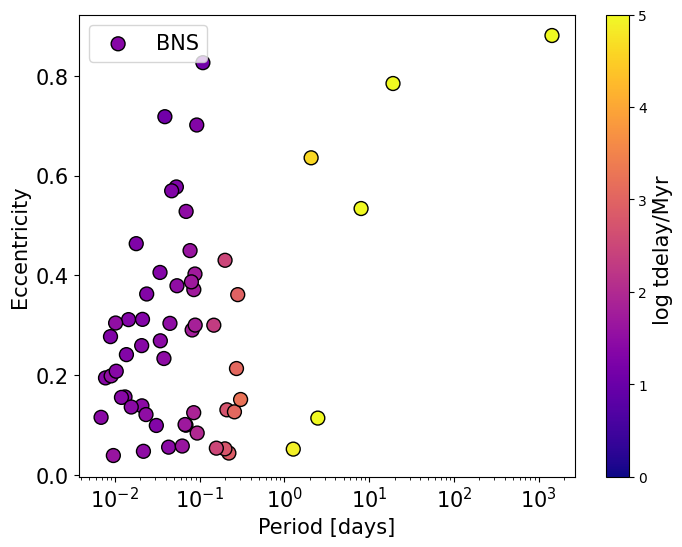

In [35]:
#Delay time
#The column GW time contains a high-precision (errors <0.3%) anaylitic estimate of the GW merger time
#Since we stop the simulation at the formation of the BCO, the delay time is just
tdelay=dffCE.GWtime+dffCE.BWorldtime #In Myr


fig=plt.figure(figsize=(8,6))

plt.scatter(365.24*dffCE.Period,dffCE.Eccentricity,c=np.log10(tdelay),vmin=0,vmax=5,label="BNS",cmap="plasma",s=100,ec="k") 
cbar = plt.colorbar()
cbar.set_label('log tdelay/Myr ',fontsize=15)
plt.legend(fontsize=15)
plt.xscale("log")
plt.xlabel("Period [days]",fontsize=15)
plt.ylabel("Eccentricity",fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 

plt.show()

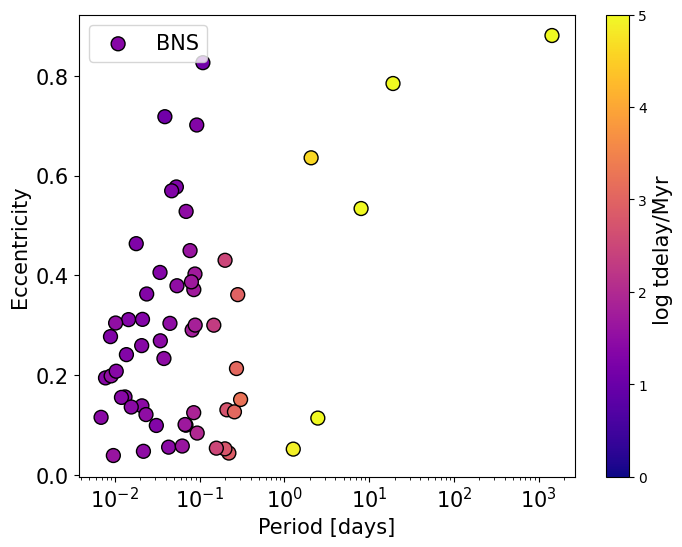

In [40]:
#Alternative, exploit the module pyblack
#The high-precision analytic approximation used to estimate the GWtime is available in the python module pyblack
#To install it use pip install pyblack 
from pyblack import estimate_tgw

#By default a (semimjoar axis) is in AU, to use it in Rsun use a_Rsun=True
GWtime=estimate_tgw(a=dffCE.Semimajor,e=dffCE.Eccentricity,m1=dffCE.Mass_0,m2=dffCE.Mass_1,a_Rsun=True)
#GWtime is in Myr

tdelay=GWtime + dffCE.BWorldtime #In Myr

fig=plt.figure(figsize=(8,6))

plt.scatter(365.24*dffCE.Period,dffCE.Eccentricity,c=np.log10(tdelay),vmin=0,vmax=5,label="BNS",cmap="plasma",s=100,ec="k") 
cbar = plt.colorbar()
cbar.set_label('log tdelay/Myr ',fontsize=15)
plt.legend(fontsize=15)
plt.xscale("log")
plt.xlabel("Period [days]",fontsize=15)
plt.ylabel("Eccentricity",fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 

plt.show()